In [1]:
import mne, os
import signal_processing.pre_process as pre_process
from basic.arrange_data import read_files

import numpy as np
import matplotlib.pyplot as plt

mne.set_log_level('error')

**Set the folder of EEG files**

Run the cell to be prompted with an input box for choosing the folder containing the EEG files of interest.

*NB! The path has to be in 'Data\Raw\' folder relative to this notebook.*

In [2]:
exp_folder = r"test" # in case you want to just type the dir here
#exp_folder = input('Experiment folder (e.g., Eyes Open\Baseline):')

raw_folder = r"Data/Raw/"
clean_folder = r"Data/Clean/"
dir_inprogress = os.path.join(raw_folder,exp_folder)
export_dir = os.path.join(clean_folder,exp_folder)

file_dirs, subject_names = read_files(dir_inprogress,".bdf")

Files in Data/Raw/test read in: 1


**Pre-process raw EEG files and save them**

1. Read raw BDF file, set EOG channels, and montage type
2. Filter data with FIR bandpass filter and remove EOG noise
3. Segment data into epochs and conduct artefact rejection and augmentation
4. Attempt to create a folder and save the cleaned signal file in FIF format (only successful if the path is empty!)

Resting state

[[188237      0      1]
 [188339      0      8]
 [434011      0      2]]


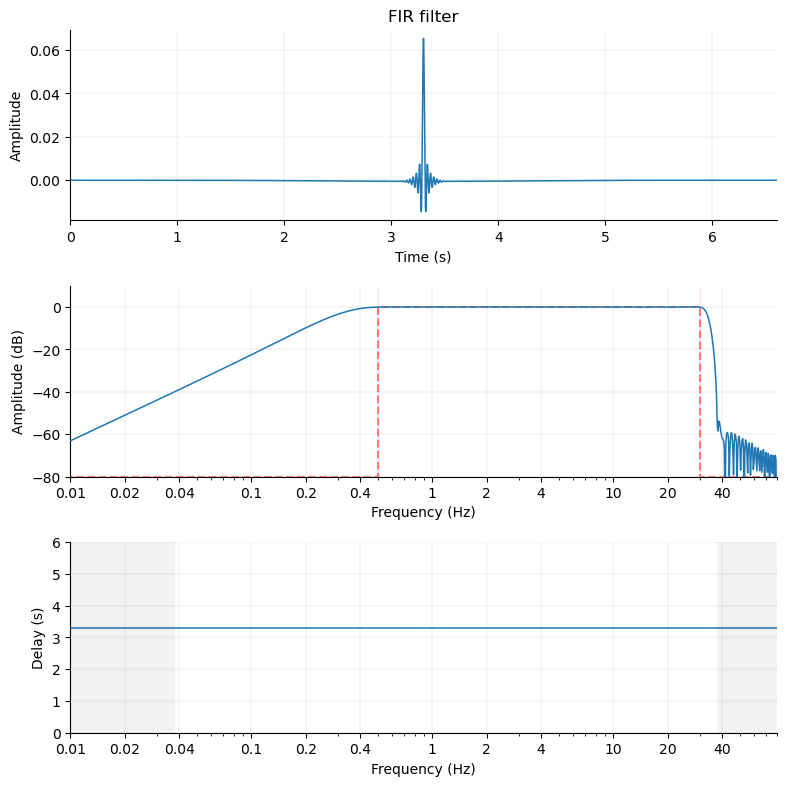

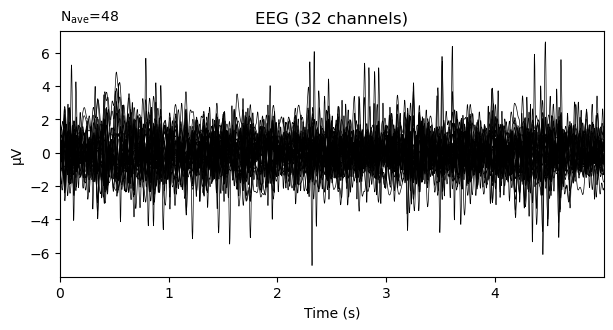

/Users/tanijarv/opt/anaconda3/envs/EEG-pipeline-TI/lib/python3.9/site-packages/mne/viz/epochs.py:543: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax['evoked'].get_shared_x_axes().join(ax['evoked'], ax_im)


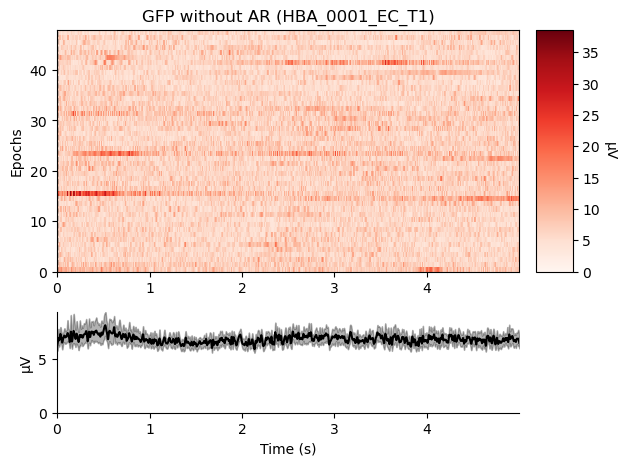

Estimating rejection dictionary for eeg
Dropping epochs with rejection threshold: {'eeg': 0.00025121512481572324}
Running autoreject on ch_type=eeg




Estimated consensus=1.00 and n_interpolate=31
No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.


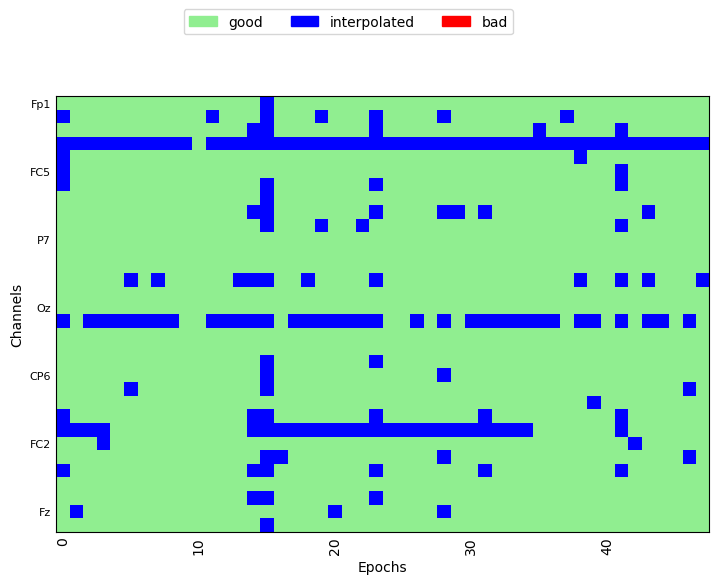

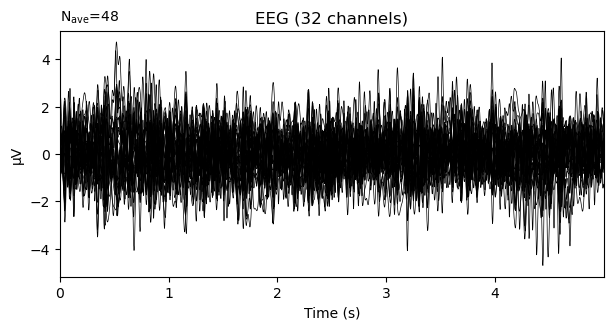

/Users/tanijarv/opt/anaconda3/envs/EEG-pipeline-TI/lib/python3.9/site-packages/mne/viz/epochs.py:543: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax['evoked'].get_shared_x_axes().join(ax['evoked'], ax_im)


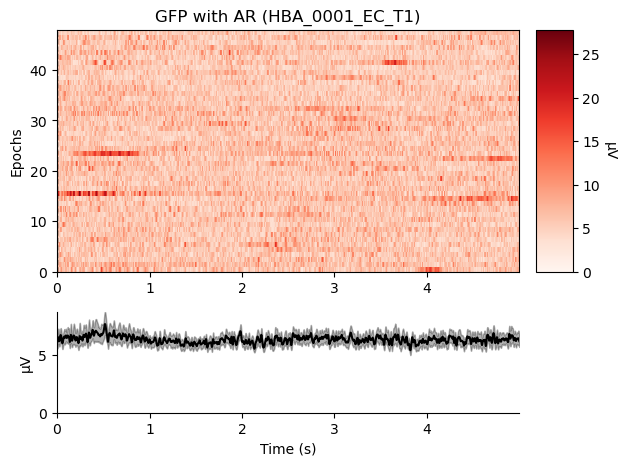

Overwriting existing file.


In [4]:
eog_channels = ["EXG1","EXG2","EXG3","EXG4","EXG5","EXG6","EXG7","EXG8"]
stimulus_channel = "Status"

for i in range(len(file_dirs)):
    raw = mne.io.read_raw_bdf(file_dirs[i],infer_types=True,eog=eog_channels,
                              stim_channel=stimulus_channel)#.drop_channels(["Erg1"])

    raw = raw.set_montage(mne.channels.make_standard_montage("biosemi32")).load_data()\
             .set_eeg_reference(ref_channels='average')

    # Find stimulus points, i.e. start and end of resting state, and crop the signal
    events = mne.find_events(raw,stim_channel=stimulus_channel,consecutive=False,output='offset')
    print(events)

    cropped_raw = raw.crop(tmin=events[0][0]/raw.info['sfreq'],tmax=events[-1][0]/raw.info['sfreq'])
    cropped_raw = cropped_raw.drop_channels(stimulus_channel)
    
    filter_design = dict(l_freq=0.5,h_freq=30,filter_length='auto',method='fir',
                         l_trans_bandwidth='auto',h_trans_bandwidth='auto',
                         phase='zero',fir_window='hamming',fir_design='firwin')
    
    # Filter the signal with bandpass filter and remove EOG artefacts with SSP
    filt = pre_process.filter_raw_data(cropped_raw,filter_design,line_remove=None,eog_channels=eog_channels,plot_filt=True,savefig=True)

    %matplotlib inline
    epochs = pre_process.artefact_rejection(filt,subject_names[i],epo_duration=5)

    # For displaying interactive EEG plots
    #%matplotlib qt
    #epochs.plot(n_channels=32,n_epochs=1)

    try:
        os.makedirs(export_dir)
    except FileExistsError:
        pass
    try:
        mne.Epochs.save(epochs,fname='{}/{}_clean-epo.fif'.format(export_dir,subject_names[i]),overwrite=True)
    except FileExistsError:
        pass